In [1]:
''' Code written by William Bidle and Ilana Zane '''

' Code written by William Bidle and Ilana Zane '

In [10]:
##########################################################################################
######################################## Imports #########################################
##########################################################################################

''' For Array Manipulation '''
import numpy as np

''' For Visualization '''
import matplotlib.pyplot as plt 

''' For Mathematical Expressions '''
from sympy import * 

''' For Runtime/Progress Checking '''
from tqdm import tqdm

''' For Dataset Usage '''
from keras.datasets import mnist

''' For File Reading/Writing '''
import os
import json

##########################################################################################
##########################################################################################
##########################################################################################

In [19]:
class NN:
        
    def __init__(self, layer_sequence, loss_function):
        
        self.activation_funcs_library = self.load_func_libraries('activation_funcs_library.txt') # load in the function library        
        
        layers = layer_sequence[::2]
        if all(isinstance(item, int) for item in layers) == True:
            self.layers = np.array(layer_sequence[::2], dtype = int)
            self.weights = self.initialize_weights(self.layers) # initialize the weights based off of the desired layer sequence
        else:
            raise Exception('Invalid Layer Sequence!')
            
        activation_funcs = layer_sequence[1::2]
        if all(isinstance(item, str) for item in activation_funcs) == True:
            self.activation_funcs = []
            for i in range(len(activation_funcs)):
                self.activation_funcs.append(self.init_func(self.activation_funcs_library, activation_funcs[i])) # initialize the desired activation functions between layers

        else:
            raise Exception('Invalid Layer Sequence!')
            
            
        self.loss_funcs_library = self.load_func_libraries('loss_funcs_library.txt')
        self.loss_func = self.init_func(self.loss_funcs_library, loss_function)
        self.loss_func_label = loss_function # used for plotting
        
        self.training_err = None # will be set later once the model is trained
        
        
        
        ''' Avaliable Class Properties '''
        # nn = NN(layer_sequence)
        # print(nn.activation_funcs_library)
        # print(nn.loss_funcs_library)
        
        # print(nn.activation_funcs)
        # print(nn.loss_func_label, nn.loss_func)
        
        # print(nn.layers)
        # print(nn.weights)
        
        # print(nn.training_err)

    ##########################################################################################
    
    def load_func_libraries(self, func_file):
    
        ''' 
        ##################################################################
                Load in the list of defined activation functions
        ##################################################################

        INPUTS:
        - func_file (string) : the filename containing the library of usable functions

        OUTPUTS:
        - func_library (dict) : a dictionary of the usable functions

        ##################### Example ######################

        func_file = 'func_library_modified.txt'
        load_func_library(func_file)
        
        '''

        with open(func_file) as f:
            data = f.read()
      
       
        func_library = json.loads(data) # reconstructing the data as a dictionary
        
        return func_library
        
    ##########################################################################################

    def init_func(self, func_library, func):

        ''' 
        ##################################################################
                        Initialize an activation function
        ##################################################################

        INPUTS:
        - func_library (dict) : a dictionary of the usable functions
        - func (string) : the mathematical expression corresponding to 'func_name' (e.g., '1/(1+exp(-x))')

        OUTPUTS:
        - expression (sympy.core.symbol.Symbol) : symbolic mathematical representation of 'func'

        ##################### Example ######################

        func_file = 'func_library_modified.txt'
        func_library = load_func_library(func_file)
        func = init_func(func_library, 'sigmoid')
        display(func)

        '''

        try:
            expression = func_library[func]
            
            x, y, y_hat = symbols('x y y_hat', real=True)
            local_dict = {'x': x, 'y': y, 'y_hat': y_hat}

            expression = parse_expr(expression, local_dict = local_dict)
            return expression
        except:
            raise Exception("Desired function '%s' does not exist within the 'func_library.'" % func)

    ##########################################################################################

    def eval_func(self, expression, vals, diff = False):

        ''' 
        ##################################################################
                        Initialize an activation function
        ##################################################################

        INPUTS:
        - expression (sympy.core.symbol.Symbol) : symbolic mathematical representation of 'func'
        - vals (tuple containing 1D lists) : the values to evaluate 'expression' with
        - diff (Boolean) : whether or not to evaluate the derivitive of 'expression' at '_input_'

        OUTPUTS:
        - result (NumPy 1D) : evaluation of 'expression' at '_input_'

        ##################### Example ######################

        func_file = 'func_library_modified.txt'
        func_library = load_func_library(func_file)
        func = init_func(func_library, 'sigmoid')
        display(func)

        _input_ = np.linspace(-10, 10, 100)
        result = eval_func(func, _input_, diff = False)

        # visualization
        plt.plot(_input_, result)
        plt.show()

        '''        
        if expression in self.activation_funcs: # Evaluate Activation Functions
            x = Symbol('x', real = True) # the variable of interest

            if diff == True: # differentiate only if the 'diff' flag is True
                expression = expression.diff(x)

            func = lambdify(x, expression) # allow the function to be evaluated from lists
            result = func(vals[0]) # evaluate the function at the given input
            
            return result
            
        
        else: # Evaluate Loss Functions
            y, y_hat = symbols('y, y_hat', real = True) # the variables of interest
            
            if diff == True: # differentiate only if the 'diff' flag is True
                expression = expression.diff(y)
                
                func = lambdify((y, y_hat), expression) # allow the function to be evaluated from lists
                result = func(vals[0], vals[1]) # evaluate the function at the given input
                return result
            
            func = lambdify((y, y_hat), expression) # allow the function to be evaluated from lists
            result = func(vals[0], vals[1]) # evaluate the function at the given input
            return sum(result)
    
    ##########################################################################################
    
    def initialize_weights(self,layer_sequence):
        layers = np.flip(layer_sequence.repeat(2)[1:-1].reshape(len(layer_sequence)-1,2), axis = 1)

        weights = [] # the list of the weights between different layers
        for i in range(len(layers)):
            weights.append(np.random.randn(layers[i][0], layers[i][1])*np.sqrt(2/layers[i][1])) # HE initialization for weights

        return weights
        
    ##########################################################################################

    def update_weights(self, weights, layer_outputs, _label_):
    
        activations = self.activation_funcs # get the list of desired activation functions

        ''' Debug '''
        # print('layer_outputs:', layer_outputs)
        # print('weights:', weights)
        # print()

        weight_updates = weights.copy()

        # blue = self.eval_MSE(layer_outputs[-1], _label_, diff = True) # blue in notes
        blue = np.diag(self.eval_func(self.loss_func, [layer_outputs[-1], _label_], diff = True)) # blue in notes
        
        ''' Debug '''
        # print('blue:', blue)
        # print()

        red = self.eval_func(activations[-1], [np.dot(weights[-1],layer_outputs[-2])], diff = True) # red in notes
        ''' Debug '''
        # print('red:', red)
        # print()

        
        for i in range(len(weights), 0, -1): # index through each weight (work backwards)
            ''' Debug '''
            # print('index i:', i - 1)

            pink = layer_outputs[i-1] # pink in notes 
            ''' Debug '''
            # print('pink:', pink)
            # print()

            grad = np.matmul(blue, np.outer(red, pink)) # first two terms in gradient
            ''' Debug '''
            # print('grad:', grad)
            # print()

            for j in range(len(weights), i, -1): # look forwards through each weight (only if there are forward weights)
                ''' Debug '''
                # print('index j:', j - 1)

                orange = np.transpose(weights[j-1]) # orange in notes
                ''' Debug '''
                # print('orange:', orange)
                # print()

                ''' I DONT KNOW IF ACTIVATIONS[J-1] IS CORRECT!!!! '''
                # print(activations[j-1])
                green = np.diag(self.eval_func(activations[j-1], [np.dot(weights[j-2],layer_outputs[j-2])], diff = True)) # green in notes
                ''' Debug '''
                # print('green:', green)
                # print()

                grad = np.matmul(green,np.matmul(orange,grad)) # now multiply the rest to grad
                ''' Debug '''
                # print('grad:', grad)
                # print()

            # print()
            weight_updates[i-1] = grad

        return weight_updates, weights
    
    ##########################################################################################
    
    def get_network_outputs(self, weights, _input_, _label_):
        
        activations = self.activation_funcs # get the list of desired activation functions
        
        current_layer = _input_
        network_outputs = [current_layer] # add the first layer to the list

        for i in range(len(weights)):

            current_layer = self.eval_func(activations[i], [np.dot(weights[i],current_layer)], diff = False)
            network_outputs.append(current_layer)

        error = self.eval_func(self.loss_func, [current_layer, _label_])

        return network_outputs, error

    ##########################################################################################
    
    
    def train(self, x_train, y_train, batch_size, epsilon = 1, visualize = False):
            
        weights = self.weights # get the list of weights 

        error_list = []

        counter = 0 # keep track of the current iteration

        weights_list = {} # create a dictionary to keep track of the weight updates (batch size)
        for i in range(len(weights)):
            weights_list[i] = [] # just a temporary blank array since training hasn't begun yet
        
        # the training
        for _input_, _label_ in tqdm(zip(x_train, y_train), total = len(x_train), desc = 'training'): # iterate through the inputs and labels

            network_output, error = self.get_network_outputs(weights, _input_, _label_) # the current network output

            weight_updates, weights = self.update_weights(weights, network_output, _label_)

            for j in range(len(weights)):
                weights_list[j].append(weight_updates[j])
        
            counter += 1

            if (counter) % batch_size == 0: 
                for j in range(len(weights)):

                    weights[j] -= epsilon*np.average(np.array(weights_list[j]), axis = 0)
                    weights_list[j] = []

            error_list.append(error)
                
        self.weights = weights
        self.training_err = error_list
        
        if visualize == True:
            fig, ax = plt.subplots(figsize = (12,6))
            
            ax.plot(self.training_err) # to visualize error over time
            
            ax.set_xlabel('Training Sample', fontsize = 14)
            ax.set_ylabel('%s Error' % self.loss_func_label, fontsize = 14)
            
            ax.grid(linestyle = '--')
            
            plt.show()
    
    ##########################################################################################
    
    def evaluate(self, x_test, y_test):

        num_correct, num_wrong = 0, 0

        for _input_, _label_ in tqdm(zip(x_test, y_test), desc = 'Evaluating Test Data', total = len(x_test)):
            network_output, error = self.get_network_outputs(self.weights, _input_, _label_) # the current network output

            ''' Debug '''

            if np.argmax(network_output[-1]) == np.argmax(_label_):
                num_correct += 1

            else:
                num_wrong += 1

        print("% Correct:", 100*num_correct/len(x_test))
        print("% Wrong:", 100*num_wrong/len(x_test))
        
    ##########################################################################################
    

##########################################################################################
#################################### Other Functions #####################################
##########################################################################################

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def One_Hot_Encode(labels):
    encoded_labels = np.zeros((len(labels), np.max(labels) + 1))
    for i in range(len(labels)):
        encoded_labels[i][labels[i]] = 1.
    return encoded_labels

##########################################################################################
##########################################################################################
##########################################################################################

In [20]:
layer_sequence = [1,'ReLU', 2]
loss_func = 'MSLE'
nn = NN(layer_sequence, loss_func)


print('activation func library:\n', nn.activation_funcs_library)
print()
print('loss func library:\n', nn.loss_funcs_library)
print()
print('current layers:\n', nn.layers)
print()
print('current weights:\n', nn.weights)
print()
print('current activation functions:\n', nn.activation_funcs)
print()
print('current loss function:\n', nn.loss_func_label, ':', nn.loss_func)
print()
print('traing error:\n', nn.training_err)

activation func library:
 {'sigmoid': '1/(1+exp(-x))', 'tanh': 'tanh(x)', 'ReLU': 'Piecewise((0,x<0),(x, x>=0))'}

loss func library:
 {'MSE': '(y - y_hat)**2', 'MAE': 'Abs(y - y_hat)', 'MAPE': '100 * Abs((y - y_hat) / (y + y_hat))', 'MSLE': '(log(y + 1.) - log(y_hat + 1.))**2'}

current layers:
 [1 2]

current weights:
 [array([[1.18967179],
       [0.46553373]])]

current activation functions:
 [Piecewise((0, x < 0), (x, True))]

current loss function:
 MSLE : (log(y + 1.0) - log(y_hat + 1.0))**2

traing error:
 None


# Example with MNIST Data for all 10 Labels

In [21]:
########################### Training Data Prep ###########################

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train.astype('float32') / 255.).reshape(len(x_train), len(x_train[0])*len(x_train[0][0]))
x_test = (x_test.astype('float32') / 255.).reshape(len(x_test), len(x_test[0])*len(x_test[0][0]))

num_data_pts = 1000

x_train = x_train[0:num_data_pts]
y_train = One_Hot_Encode(y_train[0:num_data_pts])

input_shape = x_train[0].size
output_shape = y_train[0].size

########################### Testing Data Prep ############################

num_test_evals = 1000

x_test = x_test[0:num_test_evals]
y_test = One_Hot_Encode(y_test[0:num_test_evals])

##########################################################################

training: 100%|██████████| 1000/1000 [00:28<00:00, 35.00it/s]


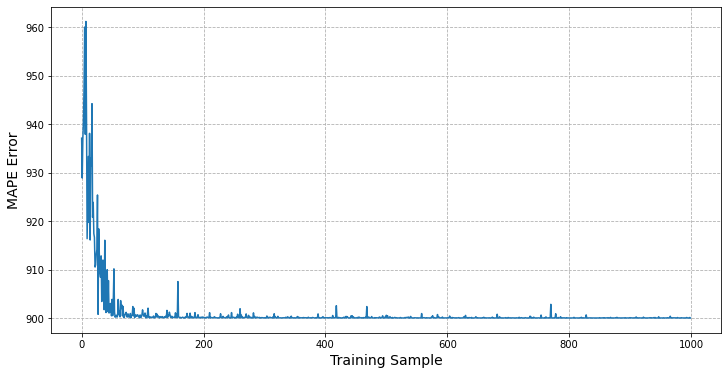

Evaluating Test Data: 100%|██████████| 1000/1000 [00:04<00:00, 225.28it/s]

% Correct: 30.3
% Wrong: 69.7


In [22]:
############################## Build network ##############################

layer_sequence = [input_shape, 'ReLU', 392, 'ReLU', 196, 'ReLU', 98, 'ReLU', 49, 'sigmoid', output_shape]
loss_function = 'MAPE'

nn = NN(layer_sequence, loss_function) # Build model 

################################# Run it ##################################

nn.train(x_train, y_train, batch_size = 5, epsilon = 0.01, visualize = True)

################################# Testing ##################################

nn.evaluate(x_test, y_test)

# Comparison of the 4 Loss functions

In [ ]:
########################### Training Data Prep ###########################

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train.astype('float32') / 255.).reshape(len(x_train), len(x_train[0])*len(x_train[0][0]))
x_test = (x_test.astype('float32') / 255.).reshape(len(x_test), len(x_test[0])*len(x_test[0][0]))

num_data_pts = 1000

x_train = x_train[0:num_data_pts]
y_train = One_Hot_Encode(y_train[0:num_data_pts])

input_shape = x_train[0].size
output_shape = y_train[0].size

########################### Testing Data Prep ############################

num_test_evals = 1000

x_test = x_test[0:num_test_evals]
y_test = One_Hot_Encode(y_test[0:num_test_evals])

##########################################################################

training: 100%|██████████| 1000/1000 [00:25<00:00, 39.03it/s]


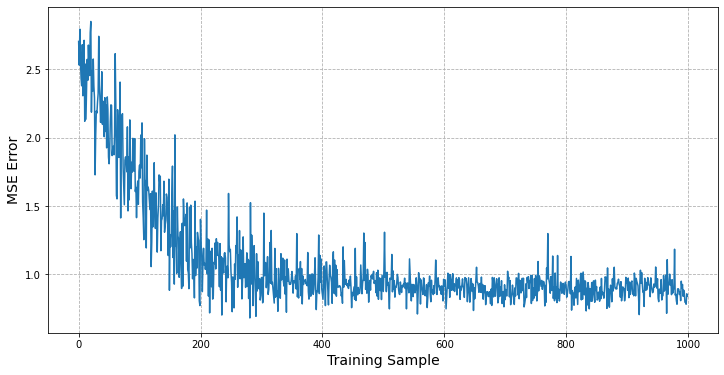

training: 100%|██████████| 1000/1000 [00:29<00:00, 34.06it/s]


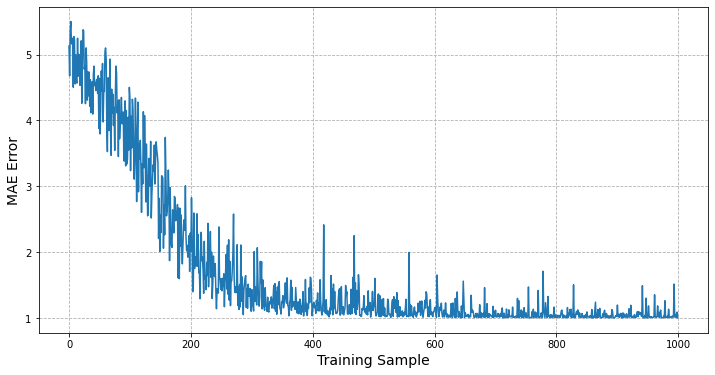

training: 100%|██████████| 1000/1000 [00:31<00:00, 31.57it/s]


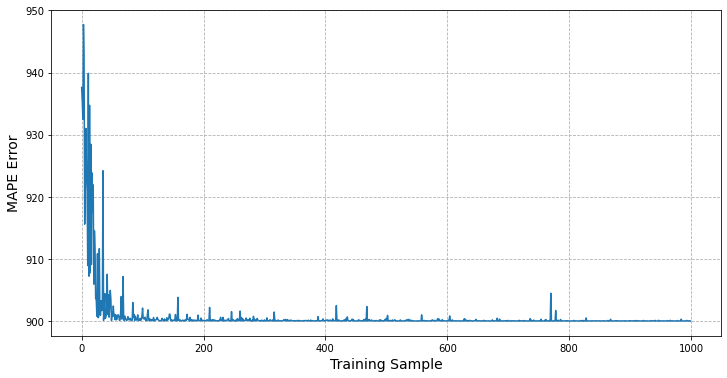

training: 100%|██████████| 1000/1000 [00:31<00:00, 31.68it/s]


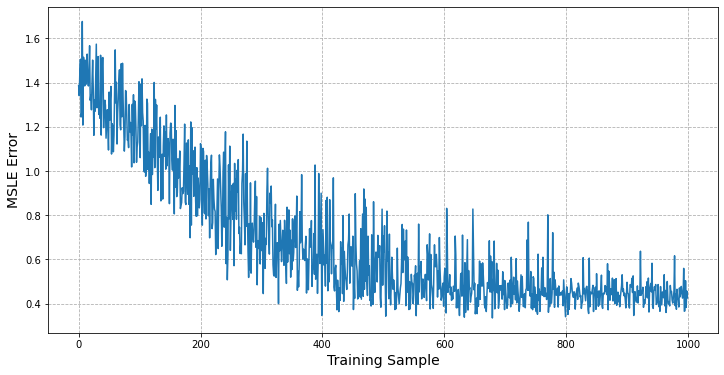

In [24]:
layer_sequence = [input_shape, 'ReLU', 392, 'ReLU', 196, 'ReLU', 98, 'ReLU', 49, 'sigmoid', output_shape]

##########################################################################
############################## Build network #############################
##########################################################################
loss_function = 'MSE'

nn1 = NN(layer_sequence, loss_function) # Build model 

################################# Run it ##################################

nn1.train(x_train, y_train, batch_size = 5, epsilon = 0.01, visualize = True)

##########################################################################
##########################################################################
##########################################################################

##########################################################################
############################## Build network #############################
##########################################################################

loss_function = 'MAE'

nn2 = NN(layer_sequence, loss_function) # Build model 

################################# Run it ##################################

nn2.train(x_train, y_train, batch_size = 5, epsilon = 0.01, visualize = True)

##########################################################################
##########################################################################
##########################################################################

##########################################################################
############################## Build network #############################
##########################################################################

loss_function = 'MAPE'

nn3 = NN(layer_sequence, loss_function) # Build model 

################################# Run it ##################################

nn3.train(x_train, y_train, batch_size = 5, epsilon = 0.01, visualize = True)

##########################################################################
##########################################################################
##########################################################################

##########################################################################
############################## Build network #############################
##########################################################################

loss_function = 'MSLE'

nn4 = NN(layer_sequence, loss_function) # Build model 

################################# Run it ##################################

nn4.train(x_train, y_train, batch_size = 5, epsilon = 0.01, visualize = True)

##########################################################################
##########################################################################
##########################################################################

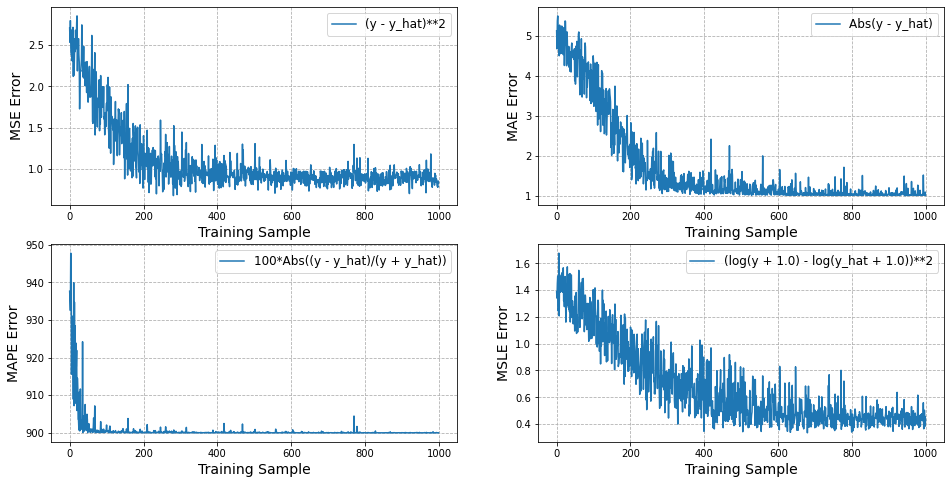

In [34]:
fig, ax = plt.subplots(2,2, figsize = (16,8))
            
ax[0][0].plot(nn1.training_err, label = '%s' % str(nn1.loss_func)) # to visualize error over time
ax[0][0].set_xlabel('Training Sample', fontsize = 14)
ax[0][0].set_ylabel('%s Error' % nn1.loss_func_label, fontsize = 14)
ax[0][0].grid(linestyle = '--')
ax[0][0].legend(fontsize = 12)

ax[0][1].plot(nn2.training_err, label = '%s' % str(nn2.loss_func)) # to visualize error over time
ax[0][1].set_xlabel('Training Sample', fontsize = 14)
ax[0][1].set_ylabel('%s Error' % nn2.loss_func_label, fontsize = 14)
ax[0][1].grid(linestyle = '--')
ax[0][1].legend(fontsize = 12)

ax[1][0].plot(nn3.training_err, label = '%s' % str(nn3.loss_func)) # to visualize error over time
ax[1][0].set_xlabel('Training Sample', fontsize = 14)
ax[1][0].set_ylabel('%s Error' % nn3.loss_func_label, fontsize = 14)
ax[1][0].grid(linestyle = '--')
ax[1][0].legend(fontsize = 12)

ax[1][1].plot(nn4.training_err, label = '%s' % str(nn4.loss_func)) # to visualize error over time
ax[1][1].set_xlabel('Training Sample', fontsize = 14)
ax[1][1].set_ylabel('%s Error' % nn4.loss_func_label, fontsize = 14)
ax[1][1].grid(linestyle = '--')
ax[1][1].legend(fontsize = 12)

plt.show()

# Try on MNIST with Only 2 labels (0 and 1)

Avaliable Function Library: {'sigmoid': '1/(1+exp(-x))', 'tanh': 'tanh(x)', 'ReLU': 'Piecewise((0,x<0),(x, x>=0))'}
Current Weights: None



training: 100%|██████████| 1000/1000 [00:27<00:00, 36.05it/s]


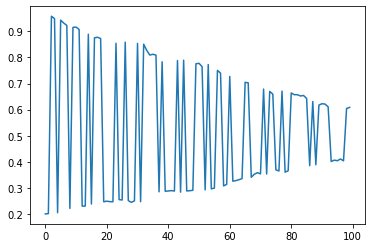

Evaluating Test Data: 100%|██████████| 1000/1000 [00:05<00:00, 197.54it/s]

% Correct: 53.1
% Wrong: 46.9


In [51]:
nn = NN()
print('Avaliable Function Library:', nn.activation_funcs_library)

print('Current Weights:', nn.weights)
print()

################################# Params #################################
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_zeros = y_train == 0
train_ones = y_train == 1

x_train = np.array(list(x_train[train_zeros]) + list(x_train[train_ones]))
y_train = np.array(list(y_train[train_zeros]) + list(y_train[train_ones]))

x_train = (x_train.astype('float32') / 255.).reshape(len(x_train), len(x_train[0])*len(x_train[0][0]))

x_train, y_train = unison_shuffled_copies(x_train, y_train)

x_train, y_train = x_train[:1000], One_Hot_Encode(y_train[:1000])

input_shape = x_train[0].size
output_shape = y_train[0].size

layer_sequence = np.array([input_shape, 392, 196, 98, 49, output_shape])

################################# Run it ##################################

error_list = nn.train(x_train, y_train, layer_sequence, activation_function = 'sigmoid', batch_size = 10, epsilon = 0.01)

# print('Current Weights =', nn.weights)

plt.plot(error_list)
plt.show()

################################# Testing ##################################

(x_train, y_train), (x_test, y_test) = mnist.load_data()

test_zeros = y_test == 0
test_ones = y_test == 1

x_test = np.array(list(x_test[test_zeros]) + list(x_test[test_ones]))
y_test = np.array(list(y_test[test_zeros]) + list(y_test[test_ones]))

x_test = (x_test.astype('float32') / 255.).reshape(len(x_test), len(x_test[0])*len(x_test[0][0]))

x_test, y_test = unison_shuffled_copies(x_test, y_test)

x_test, y_test = x_test[:1000], One_Hot_Encode(y_test[:1000])

nn.evaluate(x_test, y_test)

# Compare to TensorFlow

In [32]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.7.0


In [33]:
# mnist = tf.keras.datasets.mnist

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0



(x_train, y_train), (x_test, y_test) = mnist.load_data()


zeros_train = y_train == 0
x_train_zeros, y_train_zeros = list(x_train[zeros_train]), list(y_train[zeros_train])
zeros_test = y_test == 0
x_test_zeros, y_test_zeros = list(x_test[zeros_test]), list(y_test[zeros_test])

ones_train = y_train == 1
x_train_ones, y_train_ones = list(x_train[ones_train]), list(y_train[ones_train])
ones_test = y_test == 1
x_test_ones, y_test_ones = list(x_test[ones_test]), list(y_test[ones_test])


x_train, y_train = np.array(x_train_zeros + x_train_ones), np.array(y_train_zeros + y_train_ones)
x_test, y_test = np.array(x_test_zeros + x_test_ones), np.array(y_test_zeros + y_test_ones)


# shuffle arrays

x_train, y_train = unison_shuffled_copies(x_train, y_train)
x_test, y_test = unison_shuffled_copies(x_test, y_test)

x_train = (x_train / 255.)
x_test = (x_test / 255.)

print(x_train.shape)

(12665, 28, 28)


In [34]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation='sigmoid')
])
loss_fn = tf.keras.losses.MeanSquaredError()

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 100,738
Trainable params: 100,738
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer='SGD',
              loss=loss_fn,
              metrics=['accuracy'])

In [37]:
model.fit(x_train, y_train, batch_size= 10, epochs=5)

Epoch 1/5
1267/1267 [==============================] - 2s 909us/step - loss: 0.1003 - accuracy: 0.5672
Epoch 2/5
1267/1267 [==============================] - 1s 864us/step - loss: 0.0241 - accuracy: 0.5571
Epoch 3/5
1267/1267 [==============================] - 1s 745us/step - loss: 0.0133 - accuracy: 0.5460
Epoch 4/5
1267/1267 [==============================] - 1s 865us/step - loss: 0.0097 - accuracy: 0.5439
Epoch 5/5
1267/1267 [==============================] - 1s 741us/step - loss: 0.0077 - accuracy: 0.5416


# Softmax Developmemnt

# MAE Development

In [3]:
from sympy import *
import numpy as np

In [7]:
y, y_hat = symbols('y y_hat', real=True)

func = parse_expr('Abs(y - y_hat)', local_dict = {'y': y, 'y_hat': y_hat})
display(func)

diff = func.diff(y)
display(diff)

# a = np.array([1, 1, 1, 1, 1])
# b = np.array([2, 2, 2, 2, 2])

# sum(lambdify((y,y_hat), func)(a,b))

# ########################

# func = eval('abs(y - y_hat)')
# display(func)

# diff = func.diff(y)
# display(diff)

# a = np.array([1, 1, 1, 1, 1])
# b = np.array([2, 2, 2, 2, 2])

# sum(lambdify((y,y_hat), func)(a,b))

Abs(y - y_hat)

sign(y - y_hat)

In [9]:
x, y, y_hat = symbols('x y y_hat', real=True)

func = parse_expr('(y - y_hat)**2', local_dict = {'x': x, 'y': y, 'y_hat': y_hat})
display(func)

diff = func.diff(y)
display(diff)

(y - y_hat)**2

2*y - 2*y_hat

In [12]:
x, y, y_hat = symbols('x y y_hat', real=True)

func = parse_expr('x', local_dict = {'x': x, 'y': y, 'y_hat': y_hat})
display(func)

diff = func.diff(x)
display(diff)

x

1

In [43]:
def load_func_library(func_file):
    
    ''' 
    ##################################################################
            Load in the list of defined activation functions
    ##################################################################
    
    INPUTS:
    - func_file (string) : the filename containing the library of usable activation functions
    
    OUTPUTS:
    - func_library (dict) : a dictionary of the usable activation functions
    
    ##################### Example ######################
    
    func_file = 'func_library_modified.txt'
    load_func_library(func_file)
        
    '''
    
    if os.path.isfile(func_file): 
        with open(func_file) as f:
            data = f.read()
    else:
        raise Exception('Function file "%s" doesn\'t exist!' % func_file)
    
    # reconstructing the data as a dictionary
    func_library = json.loads(data)
    return func_library

##########################################################################################

def init_func(func_library, func):
    
    ''' 
    ##################################################################
                    Initialize an activation function
    ##################################################################
    
    INPUTS:
    - func_library (dict) : a dictionary of the usable activation functions
    - func (string) : the mathematical expression corresponding to 'func_name' (e.g., '1/(1+exp(-x))')
    
    OUTPUTS:
    - expression (sympy.core.symbol.Symbol) : symbolic mathematical representation of 'func'
    
    ##################### Example ######################
    
    func_file = 'func_library_modified.txt'
    func_library = load_func_library(func_file)
    func = init_func(func_library, 'sigmoid')
    display(func)
        
    '''
    
    try:
        expression = func_library[func]
        expression = eval(expression)
        return expression
    except:
        raise Exception("Desired function '%s' does not exist within the 'func_library.'" % func)



In [44]:
func_file = 'loss_funcs_library.txt'
expression = init_func(load_func_library(func_file),'MSE')
eval_loss_func(expression, np.array([1,1,8]),np.array([2,3,0]), diff = True)

NameError: name 'eval_loss_func' is not defined